# 1. Setup

In [1]:
!pip -q install torch torchvision scikit-learn

import os, random, numpy as np, torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt


#Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

#Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


# 2. Data & Dataloaders

In [2]:
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2023, 0.1994, 0.2010)

train_tf = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

root = "./data"
train_ds = datasets.CIFAR10(root, train=True, download=True, transform=train_tf)
test_ds  = datasets.CIFAR10(root, train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True,
                          num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=256, shuffle=False,
                          num_workers=2, pin_memory=True)

classes = train_ds.classes


100%|██████████| 170M/170M [00:13<00:00, 12.2MB/s]


# 3. Model + Train/Eval + Saves

Epoch 001 | train loss 5.133 acc 0.142 | val loss 2.583 acc 0.150
Epoch 010 | train loss 1.364 acc 0.507 | val loss 1.342 acc 0.529
Epoch 020 | train loss 0.928 acc 0.679 | val loss 0.887 acc 0.694
Epoch 030 | train loss 0.808 acc 0.723 | val loss 0.902 acc 0.688
Epoch 040 | train loss 0.764 acc 0.736 | val loss 0.793 acc 0.732
Epoch 050 | train loss 0.734 acc 0.751 | val loss 0.836 acc 0.713
Epoch 060 | train loss 0.719 acc 0.756 | val loss 0.808 acc 0.730
Epoch 070 | train loss 0.401 acc 0.862 | val loss 0.510 acc 0.830
Epoch 080 | train loss 0.392 acc 0.865 | val loss 0.497 acc 0.835


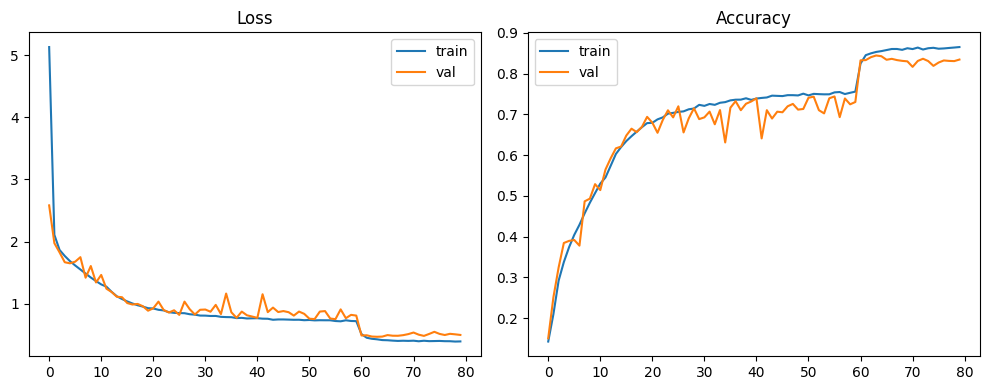

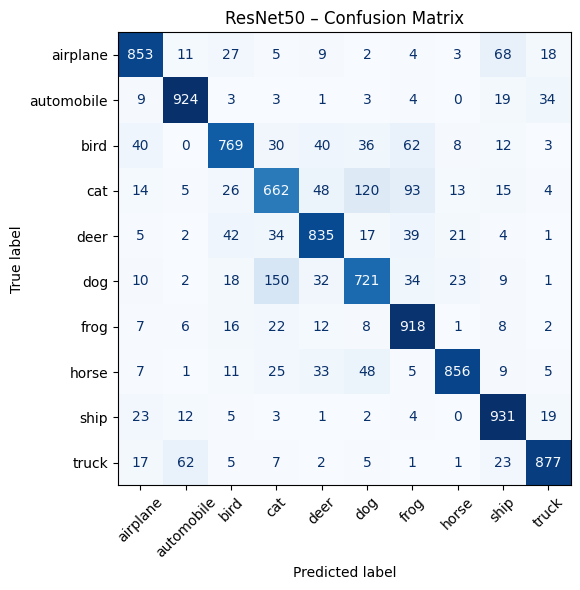

In [3]:
#Model
model = models.resnet50(weights=None)  #no pretrained to keep apples-to-apples on CIFAR10
model.fc = nn.Linear(model.fc.in_features, 10)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120], gamma=0.2)

#Train & Eval
def train_one_epoch(model, loader):
    model.train()
    loss_sum, correct, n = 0.0, 0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item() * y.size(0)
        correct  += (logits.argmax(1) == y).sum().item()
        n += y.size(0)
    return loss_sum / n, correct / n

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    loss_sum, correct, n = 0.0, 0, 0
    all_preds, all_true = [], []
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss_sum += loss.item() * y.size(0)
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        n += y.size(0)
        all_preds.append(pred.cpu()); all_true.append(y.cpu())
    import torch as _t
    return loss_sum / n, correct / n, _t.cat(all_true).numpy(), _t.cat(all_preds).numpy()

#Training loop
EPOCHS = 80  #keep reasonable
train_losses, train_accs, val_losses, val_accs = [], [], [], []

for epoch in range(1, EPOCHS+1):
    tl, ta = train_one_epoch(model, train_loader)
    vl, va, y_true, y_pred = evaluate(model, test_loader)
    scheduler.step()

    train_losses.append(tl); train_accs.append(ta)
    val_losses.append(vl);   val_accs.append(va)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | train loss {tl:.3f} acc {ta:.3f} | val loss {vl:.3f} acc {va:.3f}")

#Save learning curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(train_losses, label="train"); plt.plot(val_losses, label="val"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(train_accs, label="train"); plt.plot(val_accs, label="val"); plt.title("Accuracy"); plt.legend()
plt.tight_layout(); plt.savefig("resnet50_learning_curves.png", dpi=300, bbox_inches="tight"); plt.show()

#Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8,6)); disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
plt.title("ResNet50 – Confusion Matrix"); plt.tight_layout()
plt.savefig("resnet50_confusion_matrix.png", dpi=300, bbox_inches="tight"); plt.show()
